In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
from datasets import load_dataset
data = load_dataset("uoft-cs/cifar10")
data

d:\python workspace\Machine_Leaning\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

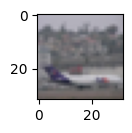

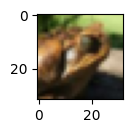

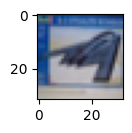

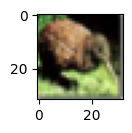

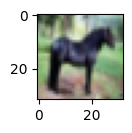

In [3]:

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(data['train']['img'][i])
    plt.show()

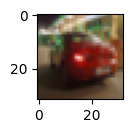

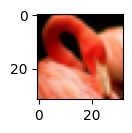

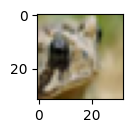

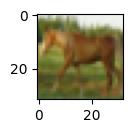

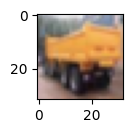

In [4]:
train_data = data['train']
test_data = data['test']
# Shuffling the training data to make sure the model does not learn the order of the data
train_data = train_data.shuffle(seed=42)
train_data = train_data[:]
test_data = test_data[:]
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(train_data['img'][i])
    plt.show()


In [5]:
# Converting the PIL type images to tensors

from torchvision import transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])
# Checking the length of the training data so I can loop through it and transofrm every PIL image to a tensor whic helps me to train the model
print(len(train_data['img']))
for i in range(len(train_data['img'])):
    train_data['img'][i] = transform(train_data['img'][i])
for i in range(len(test_data['img'])):
    test_data['img'][i] = transform(test_data['img'][i])

50000


In [6]:
# Cross checking if the images is converted to tensors or not
print(train_data['img'][:5])
train_data['label'][:5]

[tensor([[[0.1255, 0.1255, 0.1294,  ..., 0.8039, 0.6196, 0.6471],
         [0.1333, 0.1451, 0.1451,  ..., 0.7843, 0.6039, 0.6078],
         [0.1529, 0.1608, 0.1608,  ..., 0.6980, 0.5725, 0.5569],
         ...,
         [0.2275, 0.2275, 0.2275,  ..., 0.4863, 0.5059, 0.5333],
         [0.2275, 0.2275, 0.2314,  ..., 0.4863, 0.5020, 0.5216],
         [0.2275, 0.2235, 0.2353,  ..., 0.4863, 0.4941, 0.5098]],

        [[0.1098, 0.0980, 0.0941,  ..., 0.6824, 0.5529, 0.5765],
         [0.1255, 0.1137, 0.1098,  ..., 0.6392, 0.5373, 0.5529],
         [0.1412, 0.1255, 0.1216,  ..., 0.5647, 0.4941, 0.5020],
         ...,
         [0.1804, 0.1765, 0.1765,  ..., 0.4039, 0.4235, 0.4471],
         [0.1804, 0.1804, 0.1765,  ..., 0.4039, 0.4196, 0.4392],
         [0.1765, 0.1725, 0.1804,  ..., 0.4000, 0.4157, 0.4275]],

        [[0.0980, 0.1059, 0.1137,  ..., 0.4471, 0.2902, 0.3333],
         [0.1098, 0.1216, 0.1294,  ..., 0.3765, 0.2706, 0.2941],
         [0.1294, 0.1373, 0.1412,  ..., 0.2980, 0.2471, 0

[1, 2, 6, 7, 9]

In [7]:
# As now i have all the input data in the form of tensors, I will now convert the labels to tensors as well
train_data_copy = train_data.copy()
test_data_copy = test_data.copy()
train_data_copy['label'] = torch.nn.functional.one_hot(torch.tensor(train_data_copy['label'], dtype=torch.long), num_classes=10).float()
test_data_copy['label'] = torch.nn.functional.one_hot(torch.tensor(test_data_copy['label'],dtype = torch.long), num_classes=10).float()
print(train_data['label'][:5])

[1, 2, 6, 7, 9]


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device
print(train_data['img'][0].shape) # Need to check the shape to calculate dimensions for other formulas

torch.Size([3, 32, 32])


# Defining the model

In [9]:
# Input data is ready to be fed to the model
# Now I will create a model

class BeautifulModel(torch.nn.Module):
    def __init__(self):
        super(BeautifulModel, self).__init__()
        self.layer1 = torch.nn.Conv2d(3, 6, 5)
        self.dropout1 = torch.nn.Dropout(p=0.2)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.layer2 = torch.nn.Conv2d(6, 16, 5)
        self.dropout2 = torch.nn.Dropout(p=0.2)
        self.connecting_layer = torch.nn.Linear(16 * 5 * 5, 120)
        self.connecting_layer2 = torch.nn.Linear(120, 84)
        self.output_layer = torch.nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.layer1(x)))
        x = self.pool(torch.nn.functional.relu(self.layer2(x)))
        x = x.view(-1, 16
                   * 5 * 5)
        x = self.dropout1(x)
        x = torch.nn.functional.relu(self.connecting_layer(x))
        x = self.dropout1(x)
        x = torch.nn.functional.relu(self.connecting_layer2(x))
        x = self.dropout2(x)
        x = self.output_layer(x)
        return x
    

In [10]:
model = BeautifulModel()
model

BeautifulModel(
  (layer1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (dropout1): Dropout(p=0.2, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (dropout2): Dropout(p=0.2, inplace=False)
  (connecting_layer): Linear(in_features=400, out_features=120, bias=True)
  (connecting_layer2): Linear(in_features=120, out_features=84, bias=True)
  (output_layer): Linear(in_features=84, out_features=10, bias=True)
)

# Running the model

In [11]:
from sklearn.metrics import f1_score
import torch

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
batch_size = 32
epochs = 150

train_loss = []
test_loss = []
train_accuracy = []

for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0
    correct_train = 0
    total_train = 0

    for i in range(0, len(train_data_copy['img']), batch_size):
        inputs = train_data_copy['img'][i:i+batch_size]
        labels = train_data_copy['label'][i:i+batch_size]

        # Ensure that the inputs and labels are tensors
        inputs = torch.stack(inputs).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        train_loss_val = criterion(outputs, labels)
        train_loss_val.backward()
        optimizer.step()

        epoch_train_loss += train_loss_val.item()
        predicted = torch.max(outputs,1)
        labels = torch.argmax(labels,dim=1)
        total_train += labels.size(0)
        correct_train += (predicted.indices == labels).sum().item()

    avg_train_loss = epoch_train_loss / (len(train_data_copy['img']) / batch_size)
    train_accuracy.append(100 * correct_train / total_train)
    train_loss.append(avg_train_loss)
    print("-----------------------------------------------------------------------------------------")
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss}, Train Accuracy: {train_accuracy[-1]}')

    model.eval()
    epoch_test_loss = 0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        test_inputs=test_data_copy['img']
        test_labels=test_data_copy['label']
        test_labels = test_labels.to(device)
        test_inputs = torch.stack(test_inputs).to(device)
        test_output = model(test_inputs)
        test_loss_val = criterion(test_output, test_labels)
        epoch_test_loss += test_loss_val.item()
        predicted = torch.max(test_output, 1)
        test_labels = torch.argmax(test_labels, dim=1)
        correct_test += (predicted.indices == test_labels).sum().item()
        total_test = len(test_data_copy['img'])
        avg_test_loss = epoch_test_loss / total_test
        test_accuracy = 100 * correct_test / total_test
        test_loss.append(avg_test_loss)

        f1 = f1_score(test_labels.cpu(), predicted.indices.cpu(), average='weighted')
        
    print(f'Epoch {epoch+1}, Test Loss: {avg_test_loss}, Test Accuracy: {test_accuracy}, F1 Score: {f1}')

print('Model has learned its stuff')

-----------------------------------------------------------------------------------------
Epoch 1, Train Loss: 2.3003155407714844, Train Accuracy: 11.074
Epoch 1, Test Loss: 0.0002280334234237671, Test Accuracy: 11.94, F1 Score: 0.055943671303645054
-----------------------------------------------------------------------------------------
Epoch 2, Train Loss: 2.1222495809173583, Train Accuracy: 20.38
Epoch 2, Test Loss: 0.00019810173511505128, Test Accuracy: 27.35, F1 Score: 0.22466753124619548
-----------------------------------------------------------------------------------------
Epoch 3, Train Loss: 1.935471113052368, Train Accuracy: 28.85
Epoch 3, Test Loss: 0.00017558615207672118, Test Accuracy: 35.31, F1 Score: 0.31837319118784246
-----------------------------------------------------------------------------------------
Epoch 4, Train Loss: 1.7663933144378663, Train Accuracy: 35.166
Epoch 4, Test Loss: 0.0001628202199935913, Test Accuracy: 40.22, F1 Score: 0.3897805979329439
-----

### Plotting Stuff


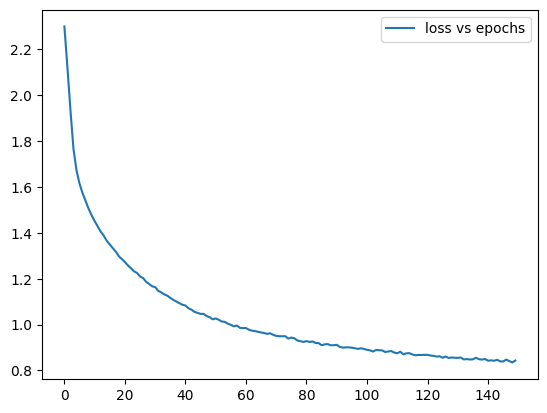

In [12]:

plt.plot(range(epochs),train_loss, label='loss vs epochs')
plt.legend()
plt.show()

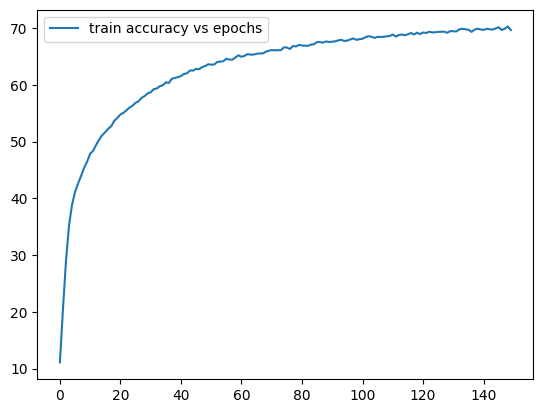

In [13]:
plt.plot(range(epochs),train_accuracy, label='train accuracy vs epochs')
plt.legend()
plt.show()

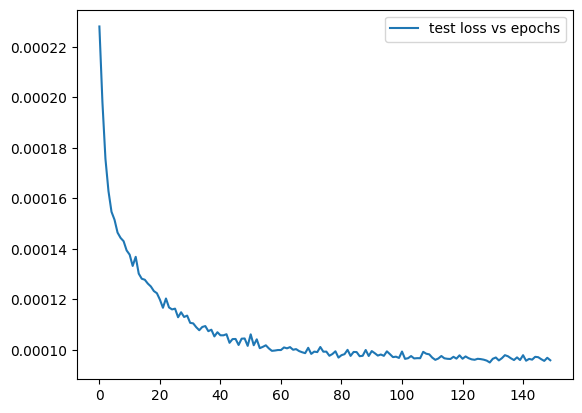

In [14]:

plt.plot(range(epochs),test_loss,  label='test loss vs epochs')
plt.legend()
plt.show()

In [15]:
torch.save(model, 'model.pth')